In [34]:
import os
from glob import glob
import random

import cv2
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
TRAIN_PATH = "../data/raw/train/"
TEST_PATH = "../data/raw/test/"

In [3]:
train_files = glob(os.path.join(TRAIN_PATH, "*.png"))
train_labels = pd.read_csv(os.path.join(TRAIN_PATH, "train_data.csv"))

In [4]:
len(train_files), len(train_labels)

(10000, 10000)

In [5]:
test_files = glob(os.path.join(TEST_PATH, "*.png"))
test_labels = pd.read_csv(os.path.join(TEST_PATH, "sample_submission.csv"))

In [6]:
len(test_files), len(test_labels)

(1000, 1000)

## Random Visualization

In [7]:
def plot_grid(files, labels=None, h=6, w=6, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, path in enumerate(random.choices(files, k=h*w)):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        image_number = path.split("/")[-1].split(".")[0]
        label = labels.loc[labels["tag"]==int(image_number)]["label"].values[0]

        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"Image: {image_number} Label: {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

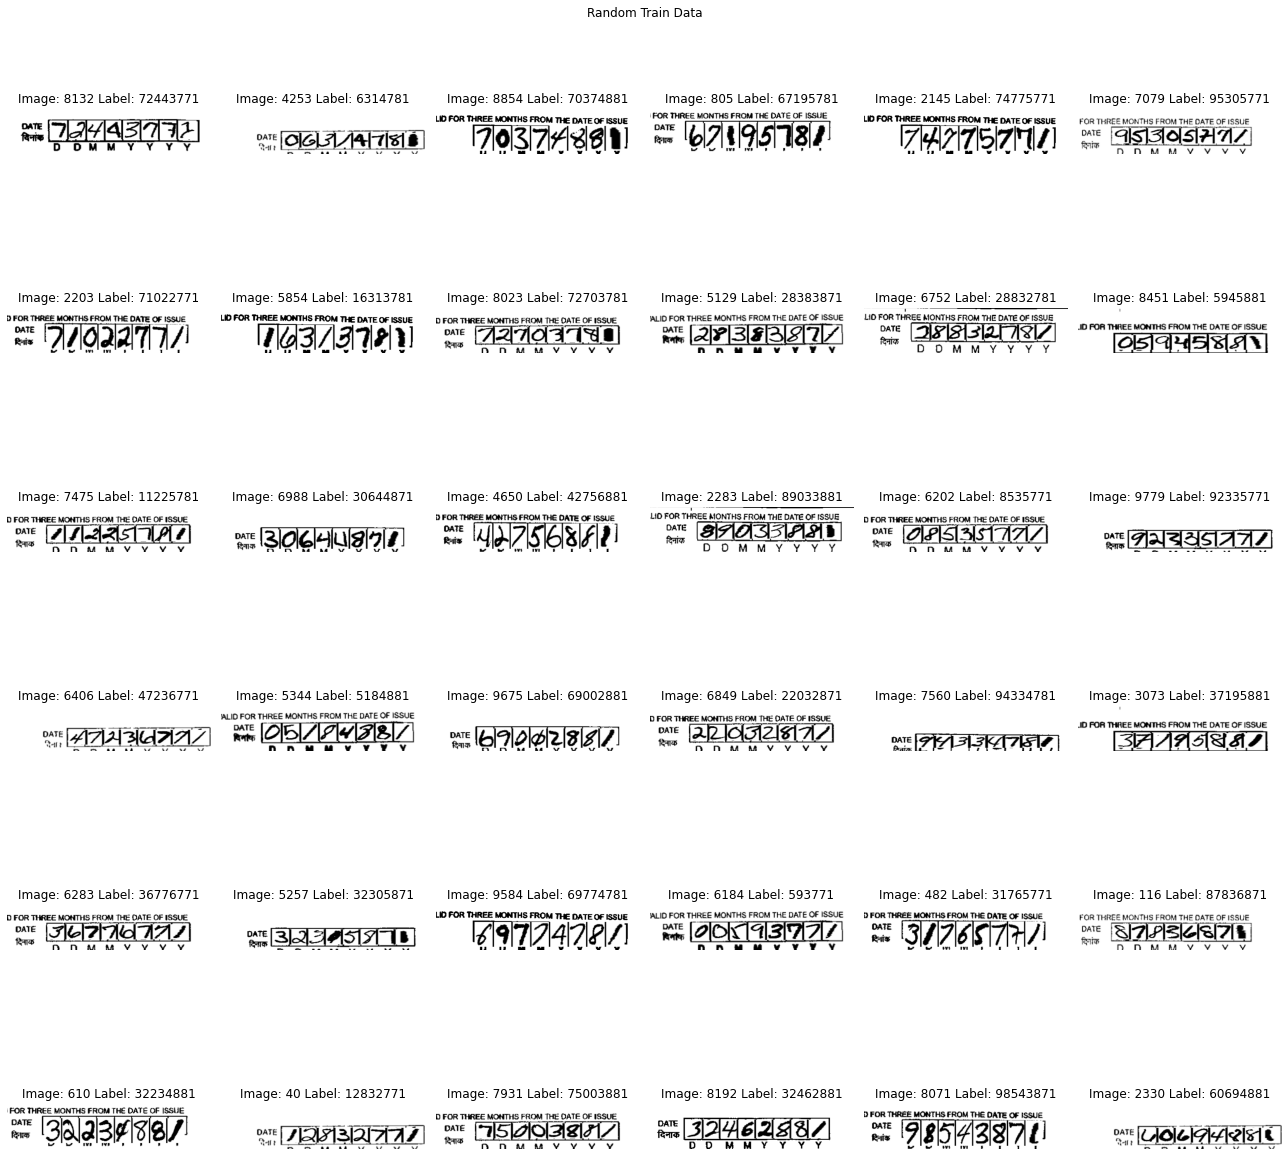

In [8]:
plot_grid(train_files, train_labels, title="Random Train Data")

**These don't look like actual dates in any sense**. Note that all the bottom text says - *DDMMYYYY* for all images

## Train Labels

In [9]:
train_labels["length"] = train_labels["label"].astype(str).str.len()

In [10]:
train_labels["length"].describe()

count    10000.000000
mean         7.892400
std          0.341517
min          5.000000
25%          8.000000
50%          8.000000
75%          8.000000
max          8.000000
Name: length, dtype: float64

**Mean length is not an integer meaning that there are some cases where date is not of the form *DD-MM-YYYY* or label is incorrect**.

In [11]:
diff = train_labels.loc[train_labels["length"]!=8]

In [12]:
diff.shape

(980, 3)

In [13]:
diff.head()

tag    label  length
7   7787   595771       6
13  9896  5034881       7
20  1317  7125871       7
25  7660  7423881       7
45  6086  5442771       7

In [14]:
diff_files = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff["tag"]]

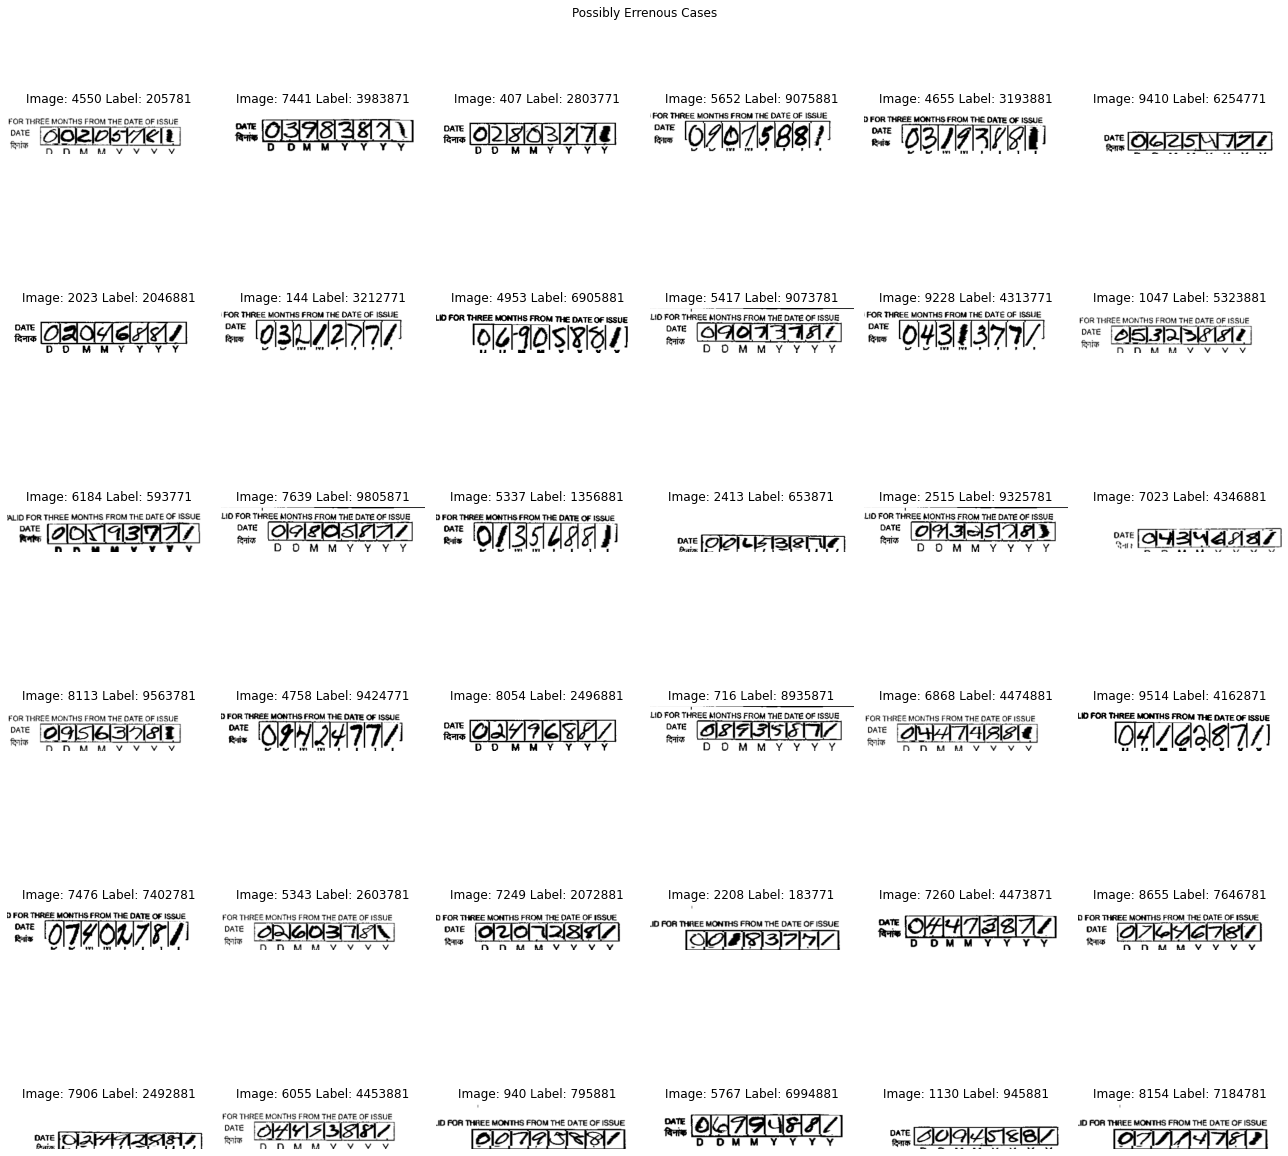

In [15]:
plot_grid(diff_files, train_labels, title="Possibly Errenous Cases")

In [16]:
train_labels["length"].value_counts()

8    9020
7     891
6      82
5       7
Name: length, dtype: int64

**Length 7 - 0 is missing at the start in label**

In [17]:
diff_len_seven = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==7]["tag"]]

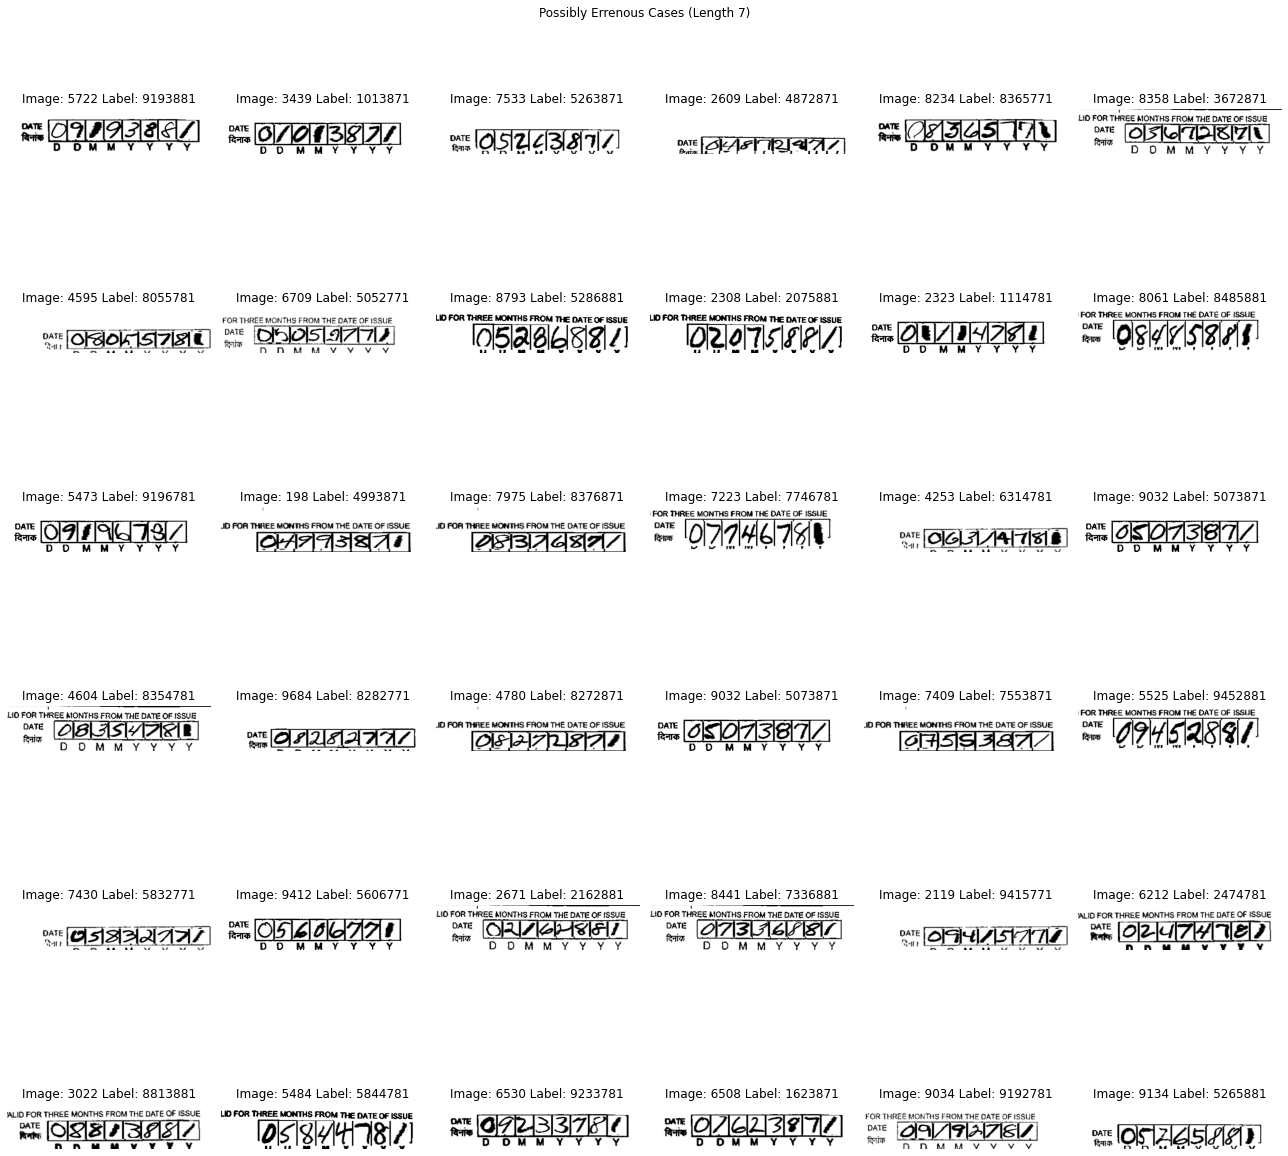

In [18]:
plot_grid(diff_len_seven, train_labels, title="Possibly Errenous Cases (Length 7)")

**Length 6 - Two 0's are missing at the start in label**

In [19]:
diff_len_six = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==6]["tag"]]

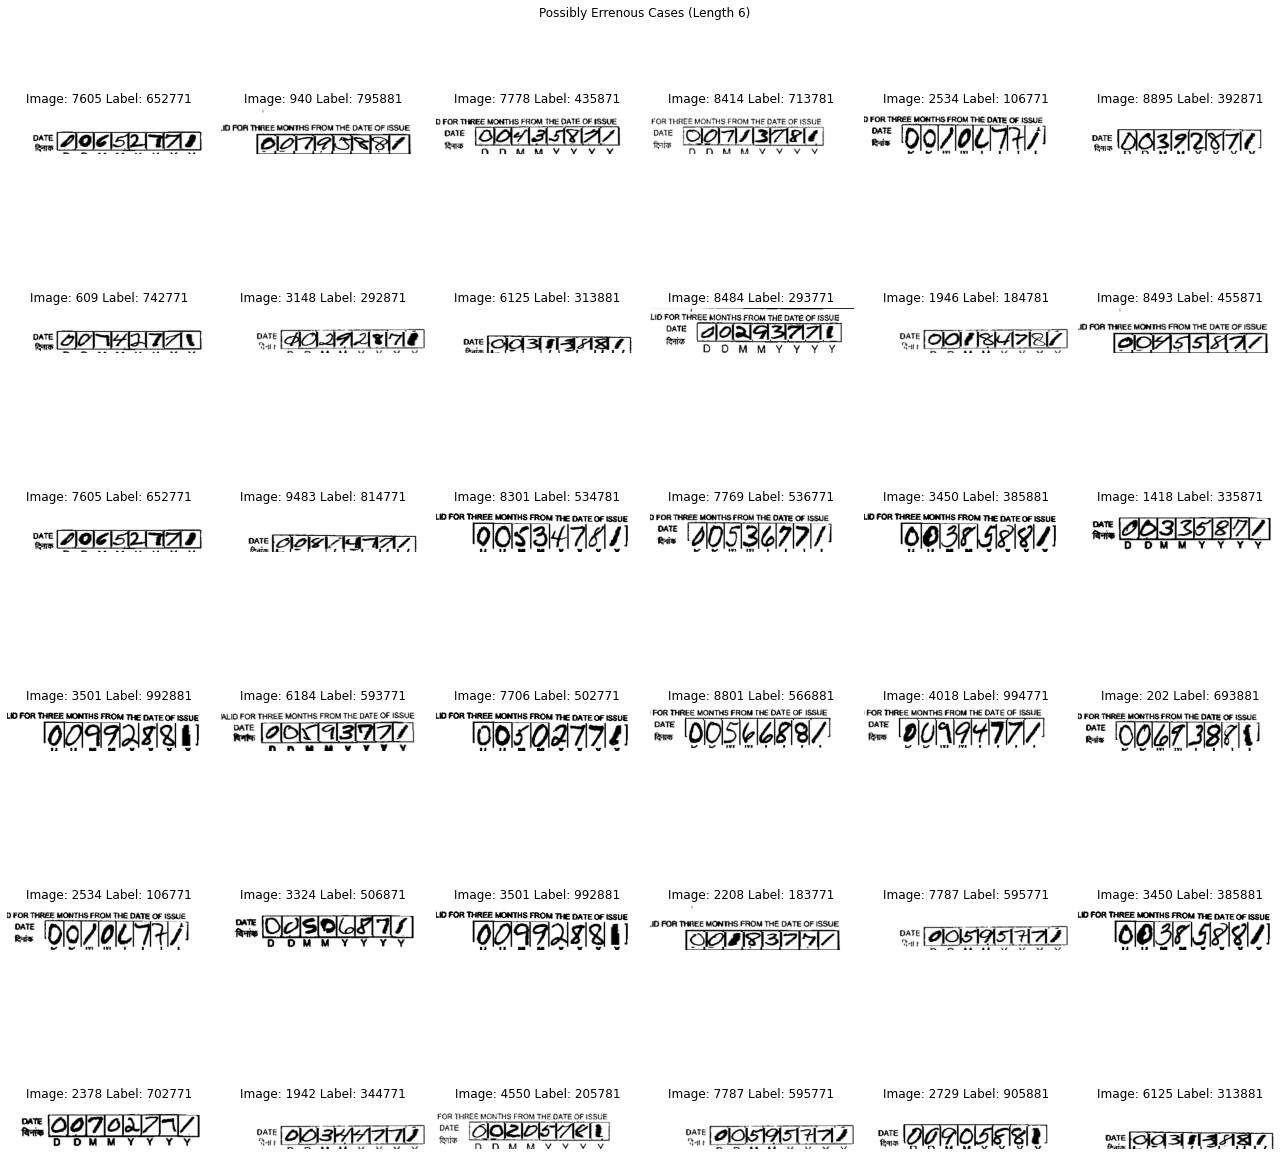

In [20]:
plot_grid(diff_len_six, train_labels, title="Possibly Errenous Cases (Length 6)")

**Length 5 - Three 0's are missing at the start in label**

In [21]:
diff_len_five = [os.path.join(TRAIN_PATH, f"{x}.png") for x in diff.loc[diff["length"]==5]["tag"]]

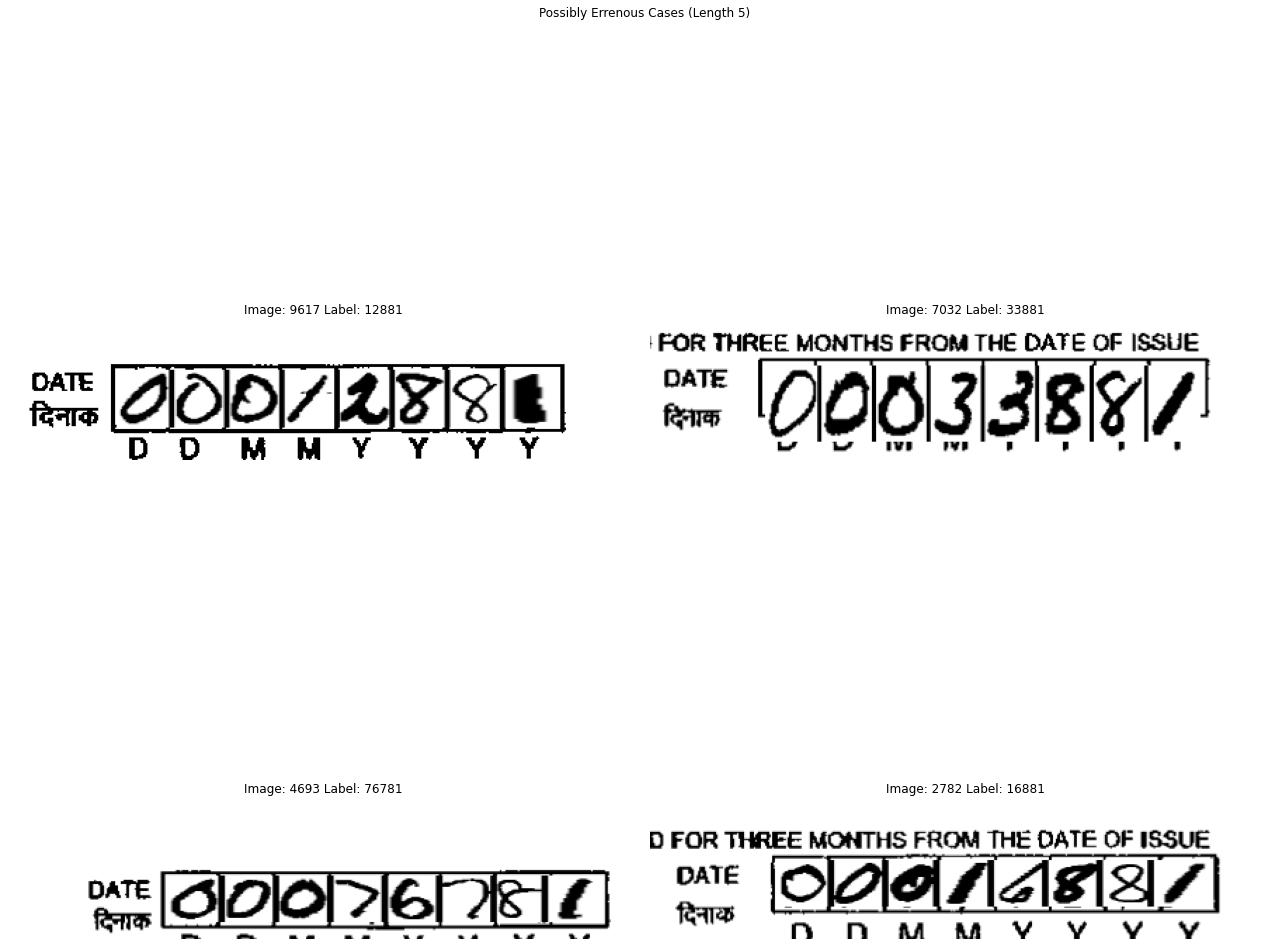

In [22]:
plot_grid(diff_len_five, train_labels, h=2, w=2, title="Possibly Errenous Cases (Length 5)")

In [23]:
train_labels["label"] = train_labels["label"].astype(str).apply(lambda x: x.zfill(8))

In [24]:
train_labels.loc[train_labels["length"]==5].head()

tag     label  length
102   4693  00076781       5
1789  8528  00044881       5
1893  9617  00012881       5
4223  6671  00085781       5
8686  2782  00016881       5

Saving corrected labels as string

In [25]:
train_labels.to_csv(os.path.join(TRAIN_PATH, "corrected_train_data.csv"), index=False)

## Modified Images

Run [visualize_rect.py](../visualize_rect.py) to generate images with cropped boxes

### Train

In [26]:
mod_train_files = glob("../data/interim/train/*.png")

In [27]:
len(mod_train_files)

393

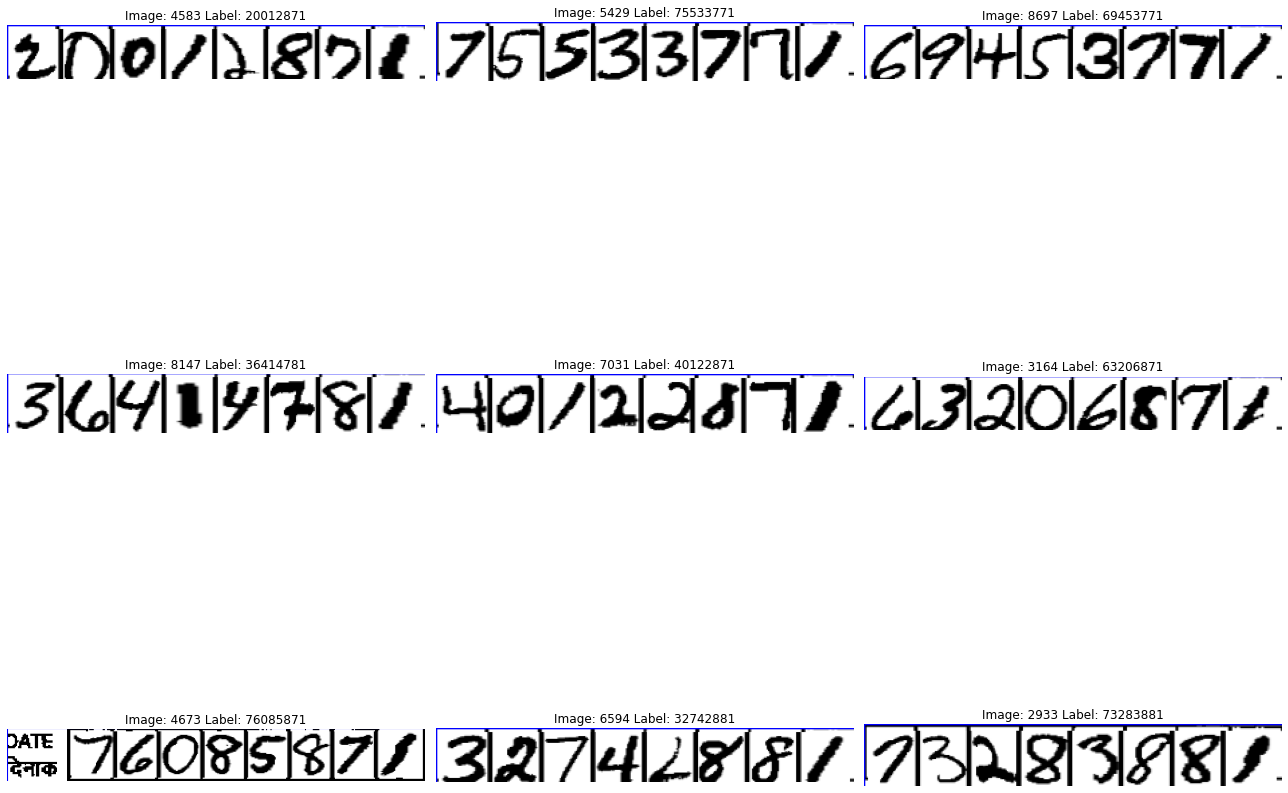

In [28]:
plot_grid(mod_train_files, train_labels, h=3, w=3)

**Modified Errenous**

In [29]:
mod_train_err_files = glob("../data/interim/train_errenous/*.png")

In [30]:
len(mod_train_err_files)

9606

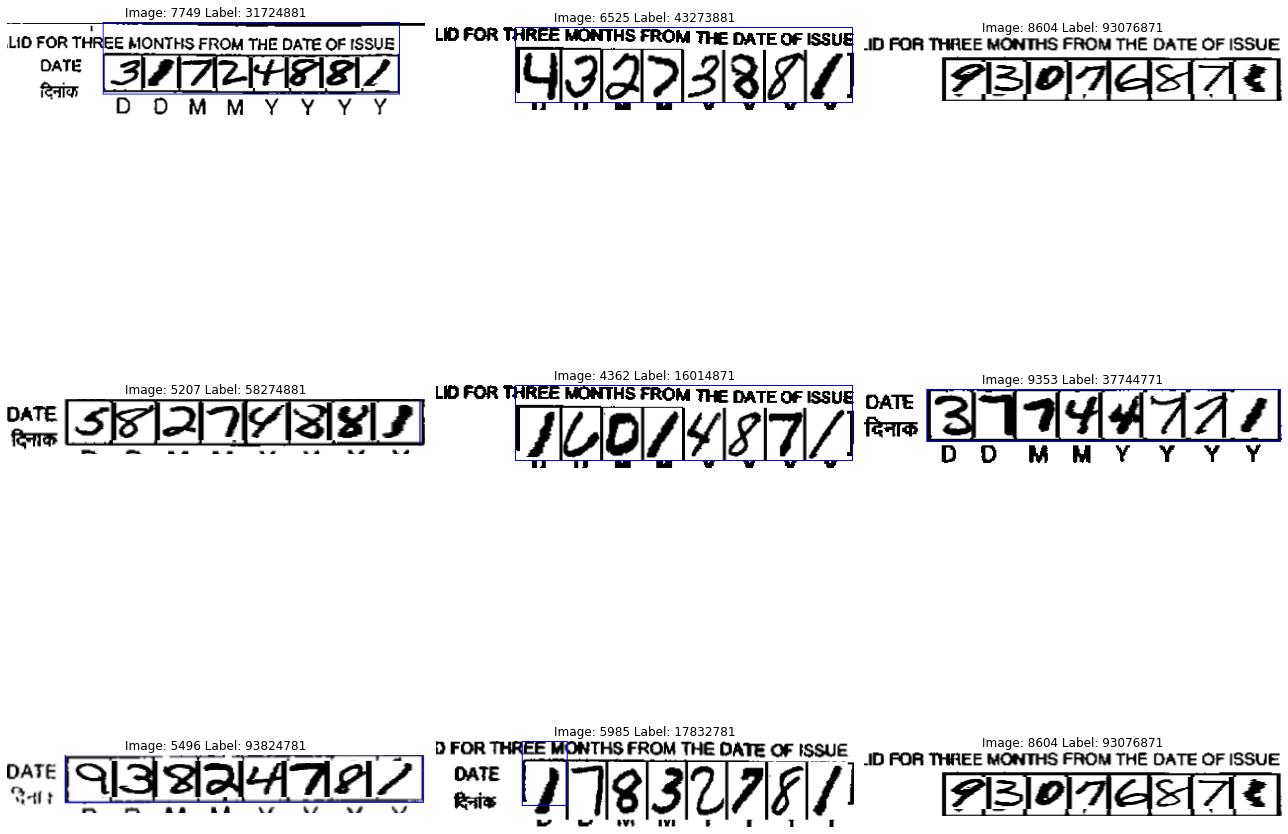

In [31]:
plot_grid(mod_train_err_files, train_labels, h=3, w=3)

### Test

In [32]:
mod_test_files = glob("../data/interim/test/*.png")

In [33]:
len(mod_test_files)

40

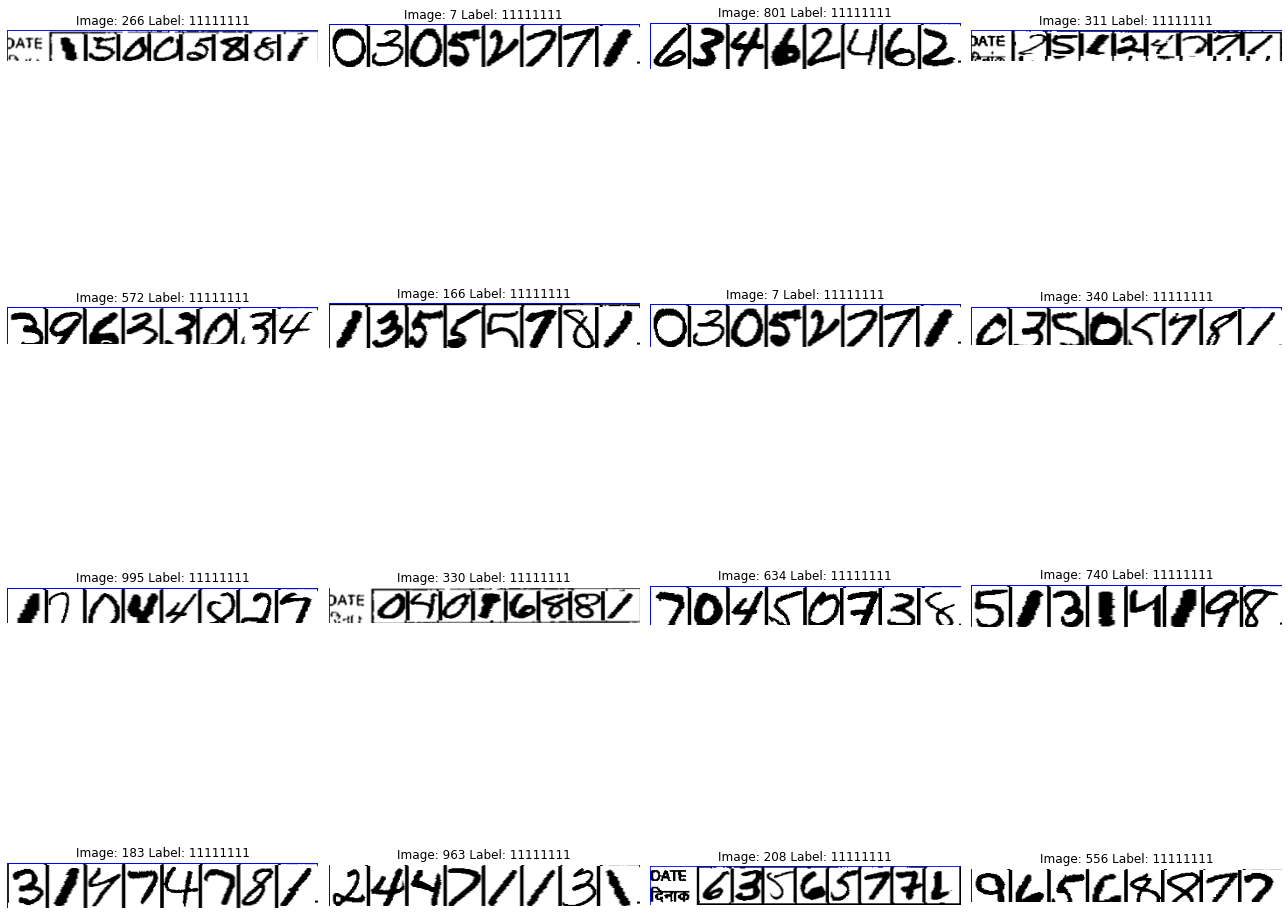

In [34]:
plot_grid(mod_test_files, test_labels, h=4, w=4)

**Modified Errenous**

In [35]:
mod_test_err_files = glob("../data/interim/test_errenous/*.png")

In [36]:
len(mod_test_err_files)

960

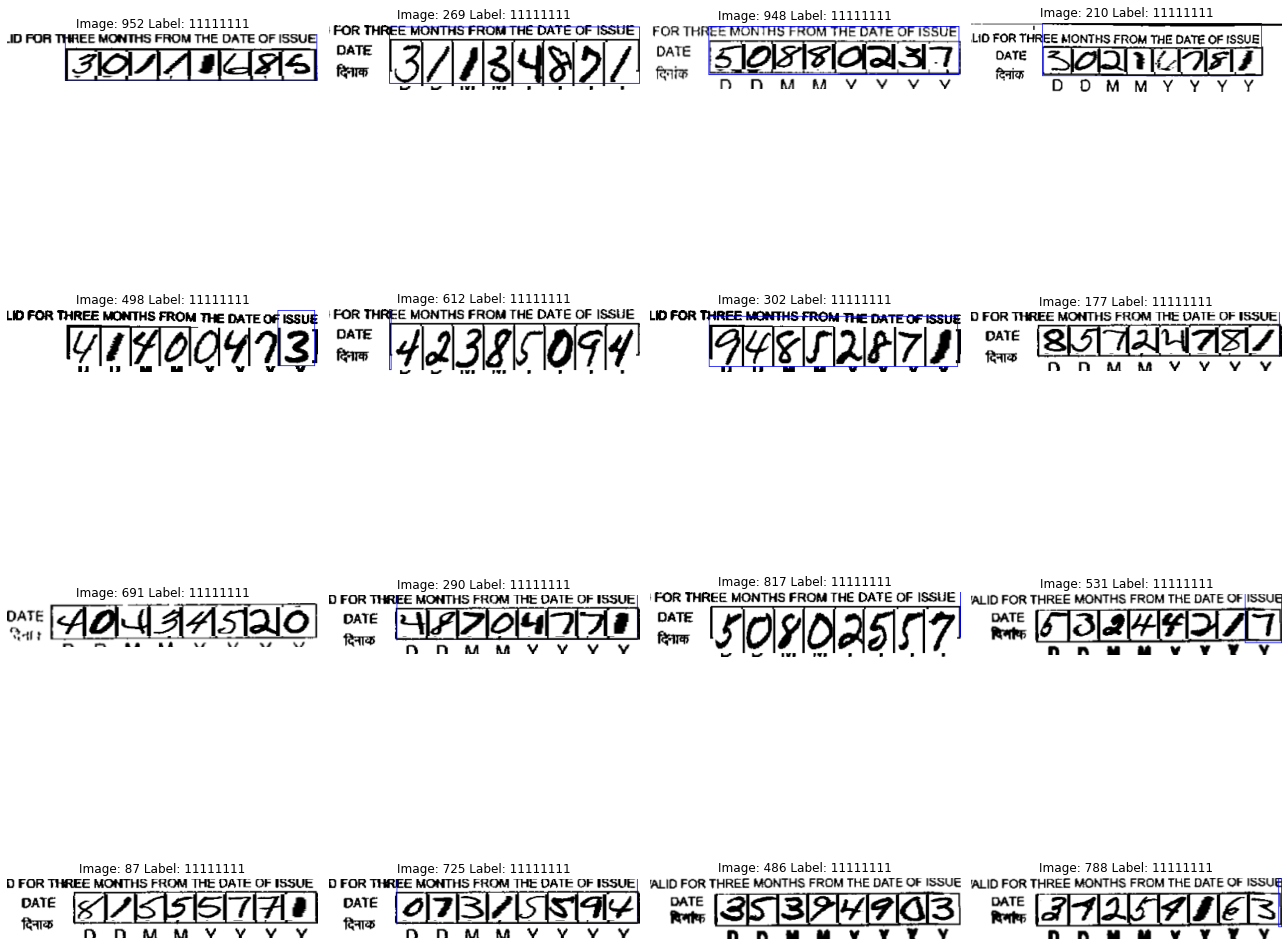

In [37]:
plot_grid(mod_test_err_files, test_labels, h=4, w=4)

## Processed Images

Run [extract_rect.py](../extract_rect.py) to crop rectangular sections. **Modified cases above are sliced so as to save dates only**. Errenous cases are stored as it is.

You can control the process - by tuning values on line 98 & 113

### Train

In [38]:
processed_train_files = glob("../data/processed/train/*.png")

In [39]:
len(processed_train_files)

10000

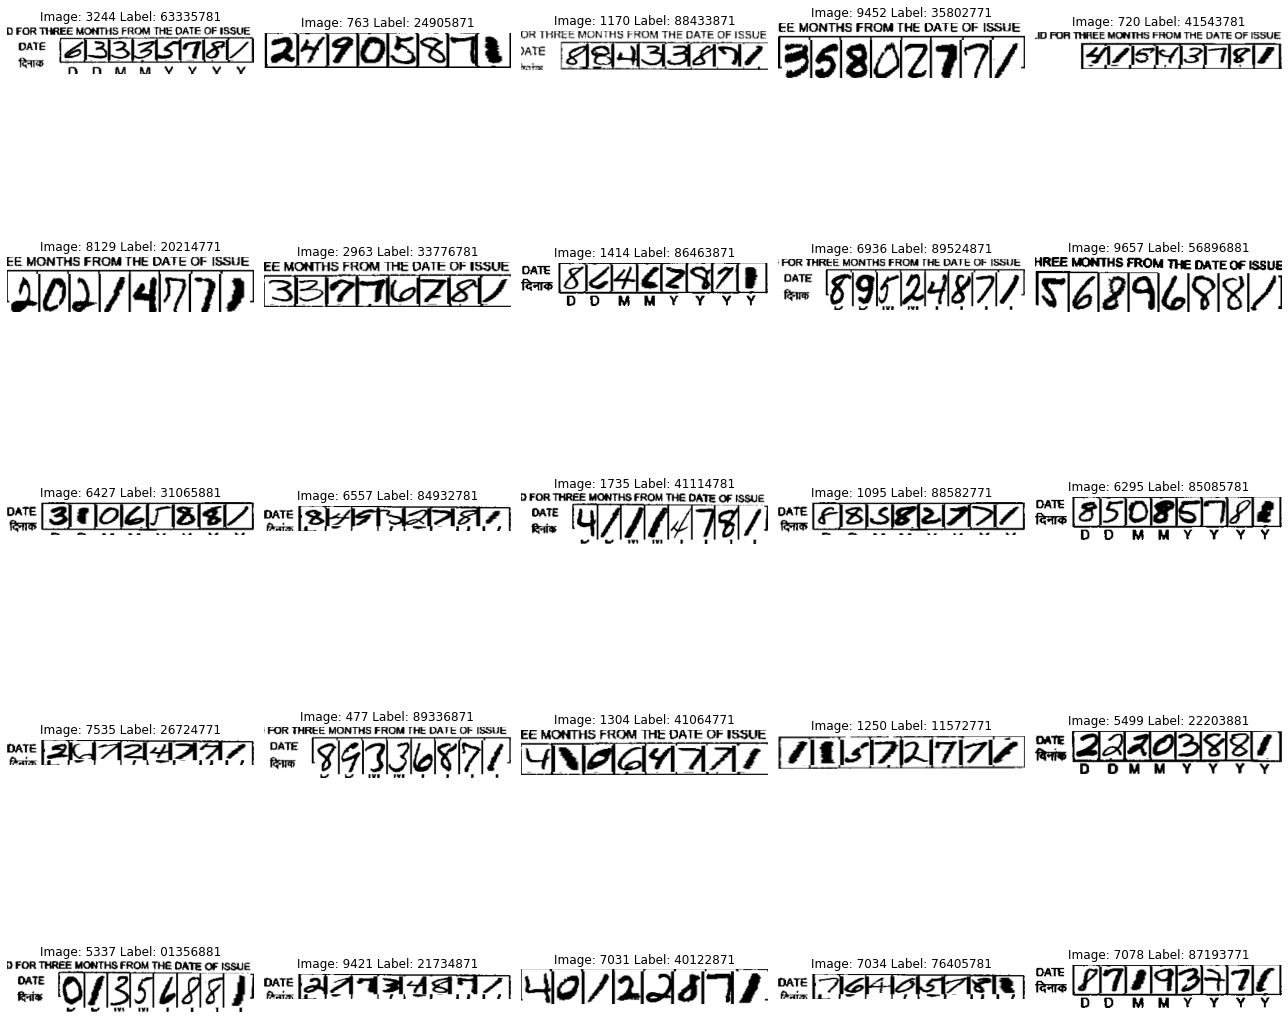

In [40]:
plot_grid(processed_train_files, train_labels, h=5, w=5)

### Test

In [41]:
processed_test_files = glob("../data/processed/test/*.png")

In [42]:
len(processed_test_files)

1000

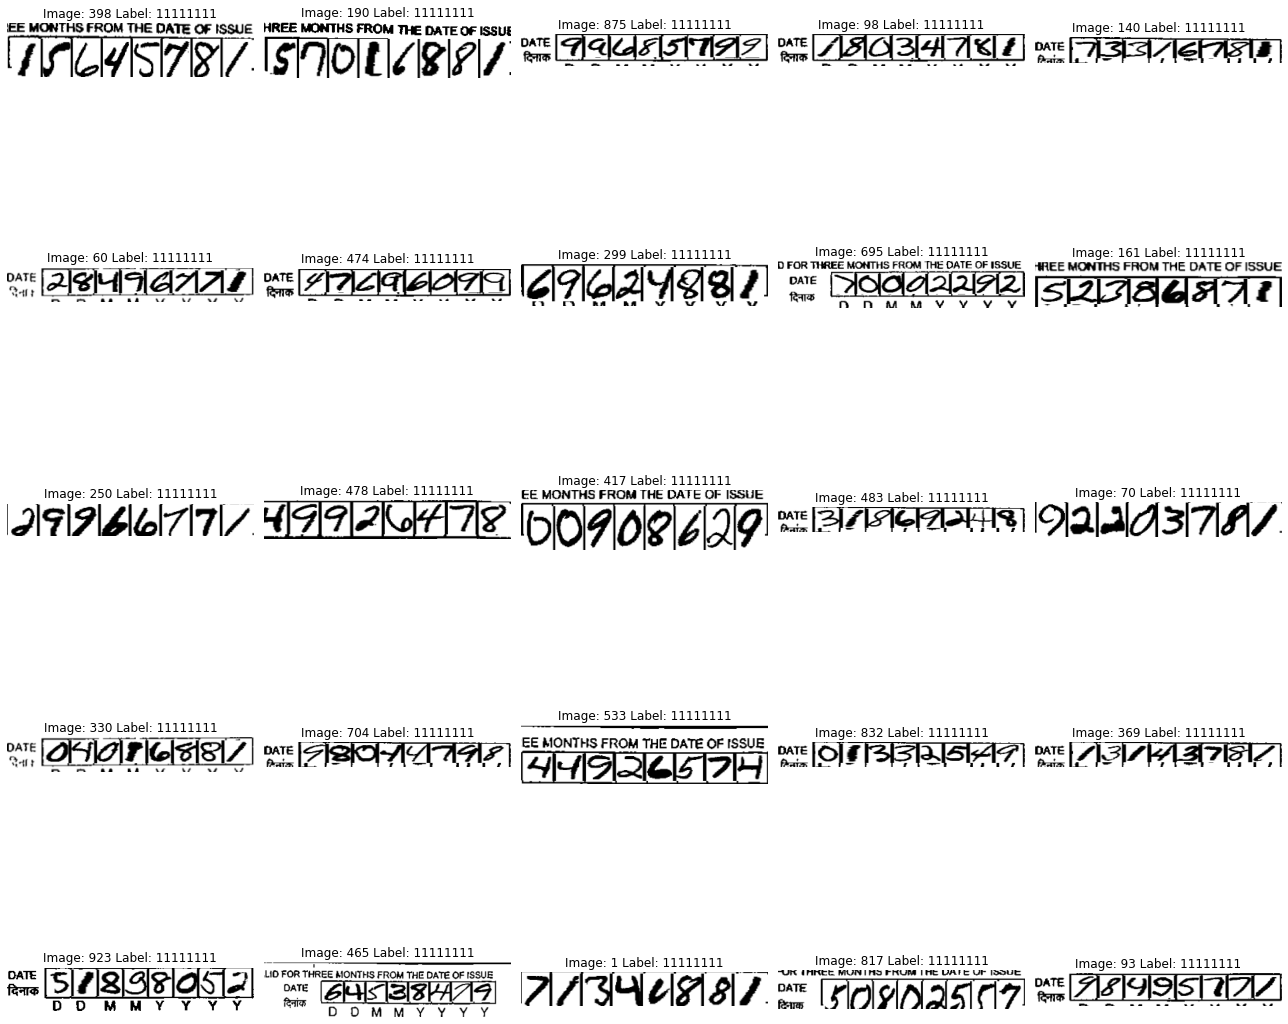

In [43]:
plot_grid(processed_test_files, test_labels, h=5, w=5)

## Digits distribution

In [44]:
for i in range(10):
    train_labels[i] = train_labels["label"].str.count(str(i))

In [45]:
train_labels.head()

tag     label  length  0  1  2  3  4  5  6  7  8  9
0  2531  17454871       8  0  2  0  0  2  1  0  2  1  0
1  2351  34053871       8  1  1  0  2  1  1  0  1  1  0
2  2763  70164781       8  1  2  0  0  1  0  1  2  1  0
3  9024  24245771       8  0  1  2  0  2  1  0  2  0  0
4  7368  94895871       8  0  1  0  0  1  1  0  1  2  2

In [46]:
for i in range(10):
    print(f"{i} - {train_labels[i].sum()}")

0 - 3979
1 - 14021
2 - 5898
3 - 6022
4 - 6074
5 - 6041
6 - 5812
7 - 14021
8 - 14155
9 - 3977


In [47]:
train_labels["label"].str[-3:].value_counts()

881    2557
871    2505
781    2470
771    2468
Name: label, dtype: int64

Digits 1,7 & 8 occur the most. Infact they occur multiple times compared to other digits and always form a triplet at the end of the number. Will that be the scenario in real life?

**However this doesn't seem to be the case with test images**

In [48]:
err = [413, 487, 512, 572, 
       605, 625, 634, 655, 
       771, 773, 801, 816, 
       869, 882]

In [49]:
err_files = [f"../data/processed/test/{x}.png" for x in err]

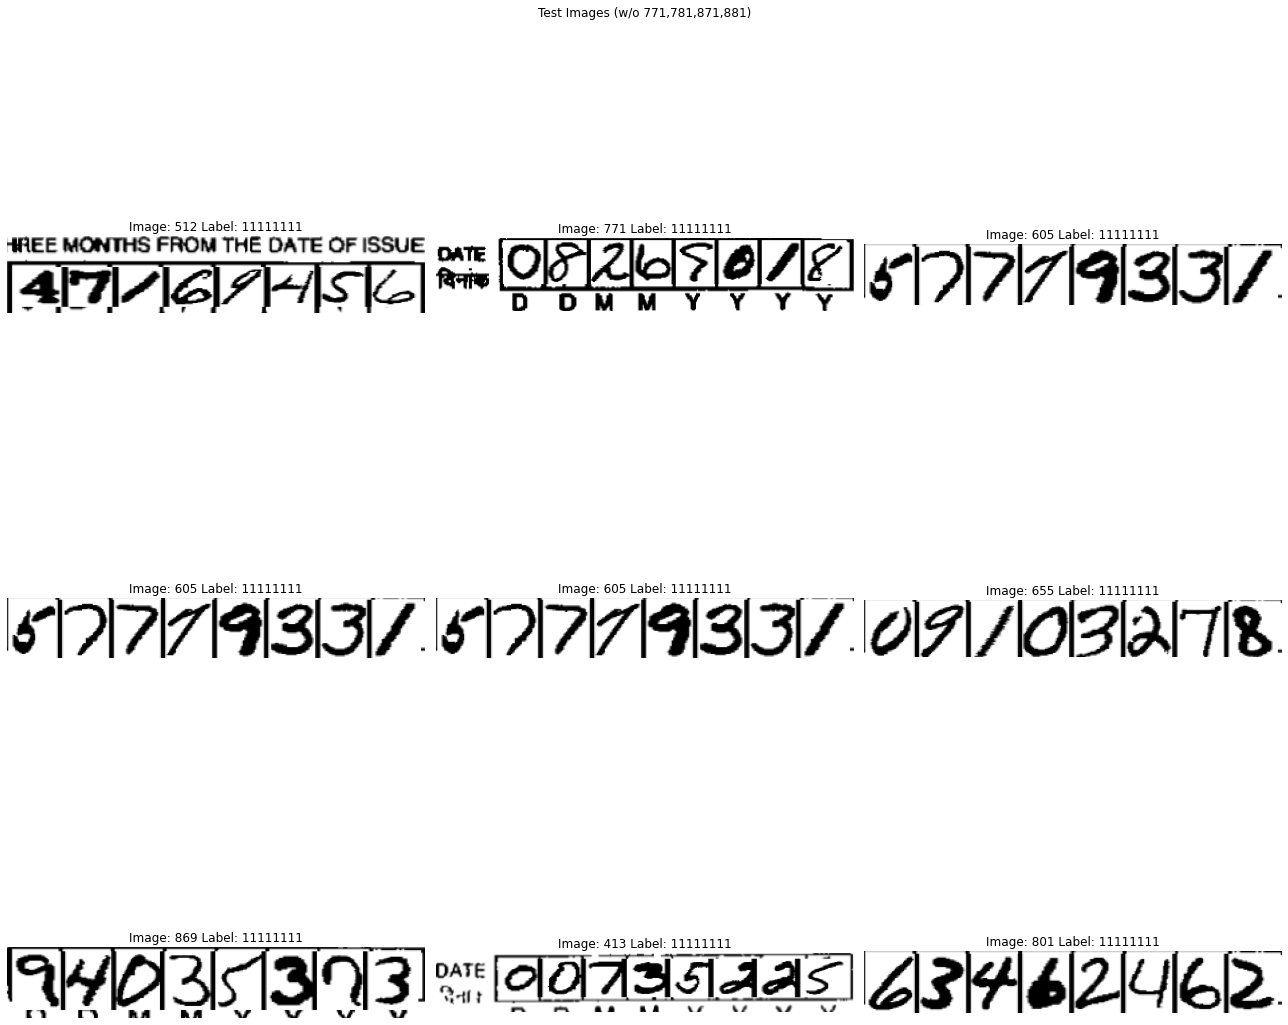

In [73]:
plot_grid(err_files, test_labels, title="Test Images (w/o 771,781,871,881)", h=3, w=3)

### Checking if stratified-folds could be made on digits distribution

In [58]:
kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=False)

In [71]:
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X=train_labels["tag"], y=train_labels[[0, 1, 2, 3, 4, 5, 6, 7, 8]])):
    print("*"*28)
    print("*"+" "*10+f"FOLD {fold}"+" "*10+"*")
    print("*"*28)
    
    print(f"Train: {len(train_idx)}")
    train_cases = train_labels.loc[train_idx]
    for i in range(10):
        print(f"{i} - {train_cases[i].sum()}")
    
    print(f"\nValidation: {len(val_idx)}")
    valid_cases = train_labels.loc[valid_idx]
    for i in range(10):
        print(f"{i} - {valid_cases[i].sum()}")
    print("\n\n")

****************************
*          FOLD 0          *
****************************
Train: 8007
0 - 3167
1 - 11210
2 - 4714
3 - 4801
4 - 4939
5 - 4833
6 - 4655
7 - 11223
8 - 11354
9 - 3160

Validation: 2005
0 - 812
1 - 2811
2 - 1184
3 - 1221
4 - 1135
5 - 1208
6 - 1157
7 - 2798
8 - 2801
9 - 817



****************************
*          FOLD 1          *
****************************
Train: 8009
0 - 3186
1 - 11230
2 - 4716
3 - 4802
4 - 4903
5 - 4823
6 - 4638
7 - 11167
8 - 11413
9 - 3194

Validation: 2005
0 - 793
1 - 2791
2 - 1182
3 - 1220
4 - 1171
5 - 1218
6 - 1174
7 - 2854
8 - 2742
9 - 783



****************************
*          FOLD 2          *
****************************
Train: 7983
0 - 3190
1 - 11211
2 - 4721
3 - 4819
4 - 4805
5 - 4838
6 - 4647
7 - 11229
8 - 11239
9 - 3165

Validation: 2005
0 - 789
1 - 2810
2 - 1177
3 - 1203
4 - 1269
5 - 1203
6 - 1165
7 - 2792
8 - 2916
9 - 812



****************************
*          FOLD 3          *
****************************
Train: 800

## Split & Stitch Images

The idea is to split cropped images with similar areas/width & combine them in different manner.

Crop cleaned images above such that 2 images with same areas are combined in the following way -
* Combine x digits of first image & y digits of second image such that x+y=8.
* Here, I loop from digits 1 to 4. That gives for a pair with same areas - 4 images

Combine the images in following ways -
* Initial part of both images
* Last part of first image & initial part of second image
* Initial part of first image & last part of second image
* Last part of both images


In [14]:
df = pd.read_csv("../cropped_image_info.csv")

In [15]:
df.shape

(560, 3)

In [16]:
df["area"] = df["height"].multiply(df["width"])

In [17]:
df = df.loc[df["path"].str.contains("train")]

In [23]:
df["tag"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))

In [24]:
df = df.sort_values(by="tag")

In [25]:
df.shape

(513, 5)

In [26]:
df.head()

path  height  width   area  tag
490   data/raw/train/2.png      41    311  12751    2
370  data/raw/train/27.png      56    377  21112   27
445  data/raw/train/42.png      44    311  13684   42
515  data/raw/train/51.png      44    312  13728   51
143  data/raw/train/66.png      37    312  11544   66

### Based on Area

In [168]:
matching_areas = df["area"].value_counts().head(10)
matching_areas

13728    75
13684    29
13104    23
12792    21
12480    19
12168    15
13772    14
13416    11
14352    10
12440    10
Name: area, dtype: int64

In [169]:
matching_areas[matching_areas>10].index.tolist()

[13728, 13684, 13104, 12792, 12480, 12168, 13772, 13416]

In [170]:
df.loc[df["area"]==13728].head()

path  height  width   area   tag
515    data/raw/train/51.png      44    312  13728    51
448   data/raw/train/584.png      44    312  13728   584
453   data/raw/train/585.png      44    312  13728   585
164   data/raw/train/628.png      44    312  13728   628
154  data/raw/train/1034.png      44    312  13728  1034

In [162]:
def stitch_images_horizontally(inp_files, height, width, digits1, digits2, comb_type="type1"):
    """
    Crops & stitches two images. 
    Crops initial `digit1` & initial `digit2` digits from corresponding images & stitches them horizontally

    Arguments
    ---------
    inp_files - list
        List of image pair paths
    
    height - int
        Image height for both images. 
    
    width - int
        Image width for both images
    
    digit1 - int
        Number of digits to take from first image

    digit2 - int
        Number of digits to take from second image
    
    comb_type - str
        Denotes combination type. 
        type1 - Initial part of both images
        type2 - Initial part of first image & last  part of second image
        type3 - Last part of first image & initial part of second image
        type4 - Last part of both images
    """
    
    images = [Image.open(x) for x in inp_files]
    
    w1 = int(width*(digits1/8))
    w2 = int(width*(digits2/8))
    
    print("Image 1")
    plt.imshow(images[0])
    plt.show()
    print("Image 2")
    plt.imshow(images[1])
    plt.show()
    
    if comb_type=="type1":
        img1_crop = images[0].crop((0, 0, w1, height))
        img2_crop = images[1].crop((0, 0, w2, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type2":
        img1_crop = images[0].crop((w1, 0, width, height))
        img2_crop = images[1].crop((0, 0, w2, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type3":
        img1_crop = images[0].crop((0, 0, w1, height))
        img2_crop = images[1].crop((w2, 0, width, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type4":
        img1_crop = images[0].crop((w1, 0, width, height))
        img2_crop = images[1].crop((w2, 0, width, height))
        images = [img1_crop, img2_crop]

        
    print("Cropped Image 1")
    plt.imshow(images[0])
    plt.show()
    print("Cropped Image 2")
    plt.imshow(images[1])
    plt.show()
    
    widths, heights = zip(*(i.size for i in images))    
    total_width = sum(widths)
    max_height = min(heights)

    new_im = Image.new("RGB", (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    print(f"Stitched Image (Image1-{digits1}, Image2-{digits2})")
    plt.imshow(new_im)
    plt.show()


Image 1


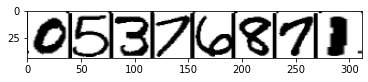

Image 2


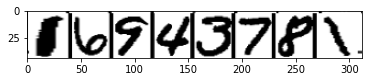

Cropped Image 1


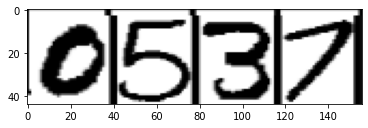

Cropped Image 2


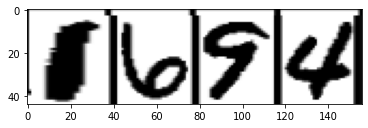

Stitched Image (Image1-4, Image2-4)


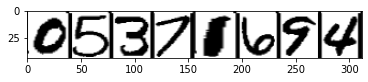

In [167]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4)

Image 1


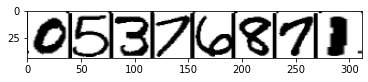

Image 2


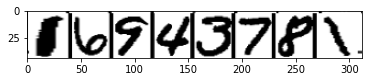

Cropped Image 1


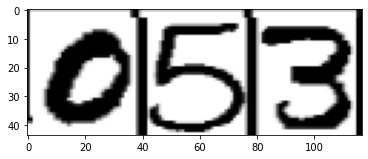

Cropped Image 2


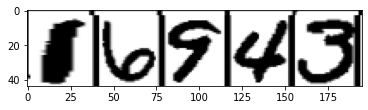

Stitched Image (Image1-3, Image2-5)


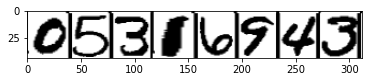

In [166]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=3, digits2=5)

Image 1


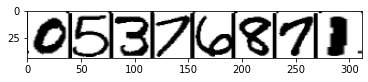

Image 2


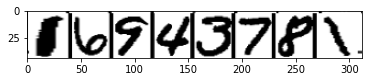

Cropped Image 1


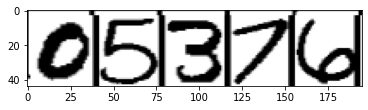

Cropped Image 2


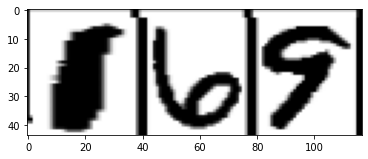

Stitched Image (Image1-5, Image2-3)


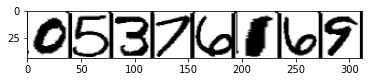

In [132]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=5, digits2=3)

Image 1


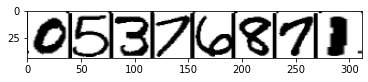

Image 2


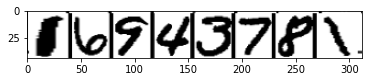

Cropped Image 1


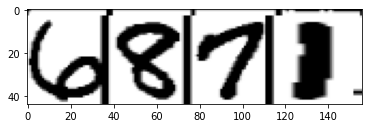

Cropped Image 2


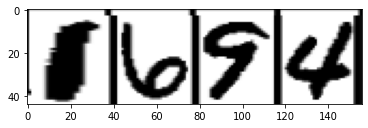

Stitched Image (Image1-4, Image2-4)


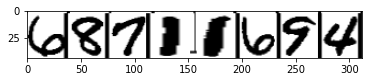

In [129]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type2")

Image 1


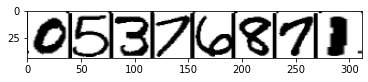

Image 2


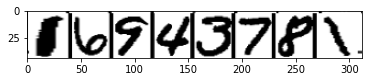

Cropped Image 1


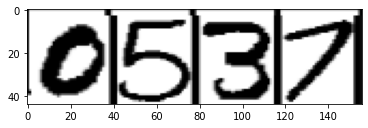

Cropped Image 2


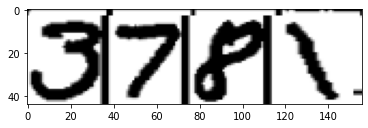

Stitched Image (Image1-4, Image2-4)


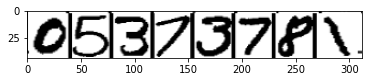

In [130]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type3")

Image 1


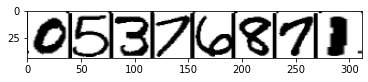

Image 2


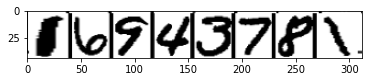

Cropped Image 1


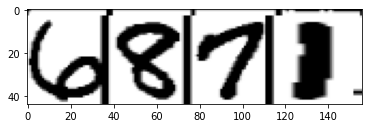

Cropped Image 2


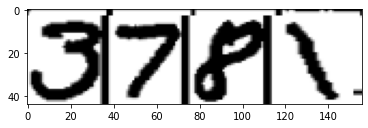

Stitched Image (Image1-4, Image2-4)


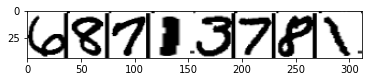

In [131]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type4")

Image 1


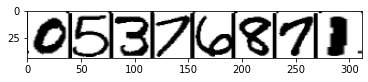

Image 2


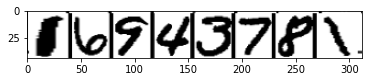

Cropped Image 1


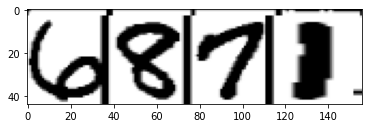

Cropped Image 2


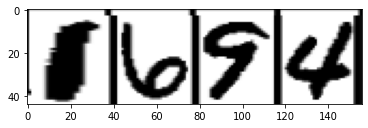

Stitched Image (Image1-4, Image2-4)


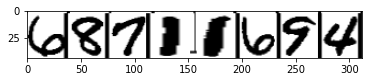

In [153]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type2")

### Based on Width

In [171]:
matching_width = df["width"].value_counts().head(10)
matching_width

312    213
311     76
313     42
315     16
314     12
379     12
366     12
372     10
362      8
378      8
Name: width, dtype: int64

In [172]:
matching_width[matching_width>10].index.tolist()

[312, 311, 313, 315, 314, 379, 366]

In [174]:
df.loc[df["width"]==311].head()

path  height  width   area  tag
490    data/raw/train/2.png      41    311  12751    2
445   data/raw/train/42.png      44    311  13684   42
325  data/raw/train/257.png      44    311  13684  257
47   data/raw/train/348.png      40    311  12440  348
100  data/raw/train/410.png      42    311  13062  410

In [182]:
df.loc[df["width"]==311]["height"].value_counts()

44    29
40    10
39     8
41     6
42     4
37     4
43     3
38     3
36     3
46     2
45     2
35     1
34     1
Name: height, dtype: int64

In [175]:
def stitch_images_horizontally(inp_files, height, width, digits1, digits2, comb_type="type1"):
    """
    Crops & stitches two images. 
    Crops initial `digit1` & initial `digit2` digits from corresponding images & stitches them horizontally

    Arguments
    ---------
    inp_files - list
        List of image pair paths
    
    height - int
        Image height for both images. 
    
    width - int
        Image width for both images
    
    digit1 - int
        Number of digits to take from first image

    digit2 - int
        Number of digits to take from second image
    
    comb_type - str
        Denotes combination type. 
        type1 - Initial part of both images
        type2 - Initial part of first image & last  part of second image
        type3 - Last part of first image & initial part of second image
        type4 - Last part of both images
    """
    
    images = [Image.open(x) for x in inp_files]
    
    w1 = int(width*(digits1/8))
    w2 = int(width*(digits2/8))
    
    print("Image 1")
    plt.imshow(images[0])
    plt.show()
    print("Image 2")
    plt.imshow(images[1])
    plt.show()
    
    if comb_type=="type1":
        img1_crop = images[0].crop((0, 0, w1, height))
        img2_crop = images[1].crop((0, 0, w2, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type2":
        img1_crop = images[0].crop((w1, 0, width, height))
        img2_crop = images[1].crop((0, 0, w2, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type3":
        img1_crop = images[0].crop((0, 0, w1, height))
        img2_crop = images[1].crop((w2, 0, width, height))
        images = [img1_crop, img2_crop]
    elif comb_type=="type4":
        img1_crop = images[0].crop((w1, 0, width, height))
        img2_crop = images[1].crop((w2, 0, width, height))
        images = [img1_crop, img2_crop]

        
    print("Cropped Image 1")
    plt.imshow(images[0])
    plt.show()
    print("Cropped Image 2")
    plt.imshow(images[1])
    plt.show()
    
    widths, heights = zip(*(i.size for i in images))    
    total_width = sum(widths)
    max_height = min(heights)

    new_im = Image.new("RGB", (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    print(f"Stitched Image (Image1-{digits1}, Image2-{digits2})")
    plt.imshow(new_im)
    plt.show()


Image 1


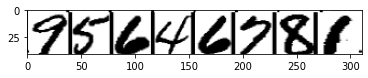

Image 2


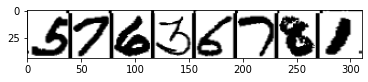

Cropped Image 1


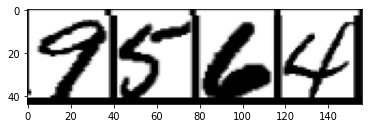

Cropped Image 2


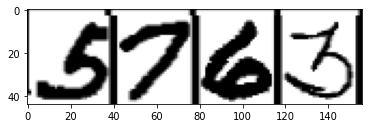

Stitched Image (Image1-4, Image2-4)


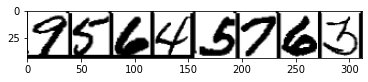

In [176]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4)

Image 1


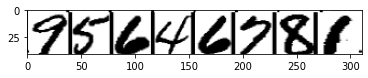

Image 2


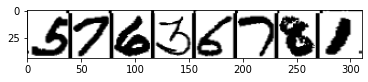

Cropped Image 1


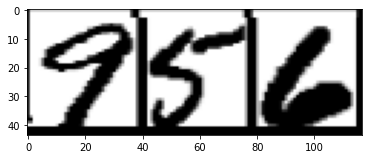

Cropped Image 2


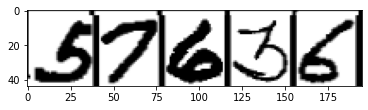

Stitched Image (Image1-3, Image2-5)


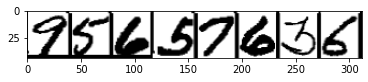

In [177]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=3, digits2=5)

Image 1


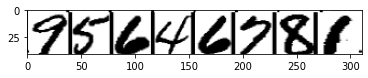

Image 2


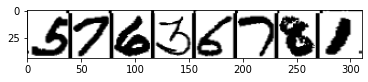

Cropped Image 1


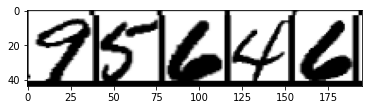

Cropped Image 2


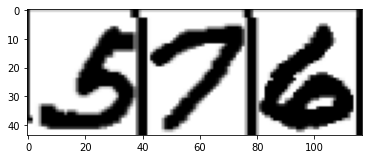

Stitched Image (Image1-5, Image2-3)


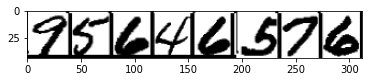

In [178]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=5, digits2=3)

Image 1


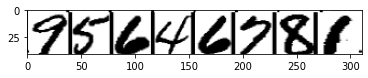

Image 2


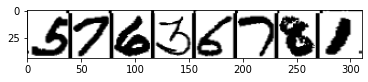

Cropped Image 1


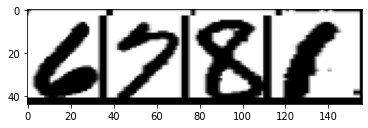

Cropped Image 2


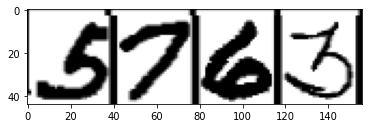

Stitched Image (Image1-4, Image2-4)


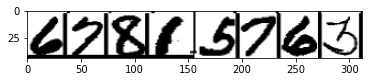

In [179]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type2")

Image 1


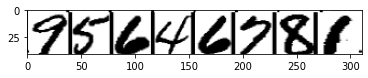

Image 2


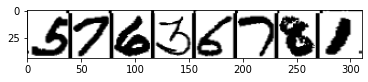

Cropped Image 1


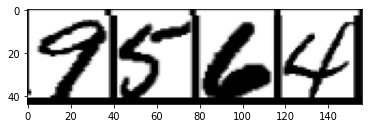

Cropped Image 2


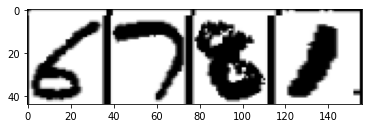

Stitched Image (Image1-4, Image2-4)


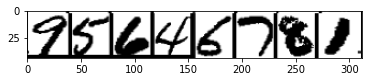

In [180]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type3")

Image 1


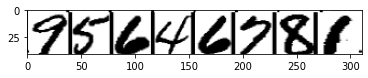

Image 2


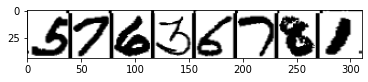

Cropped Image 1


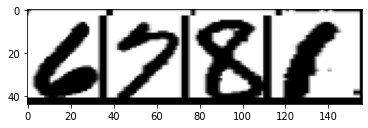

Cropped Image 2


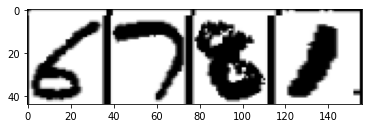

Stitched Image (Image1-4, Image2-4)


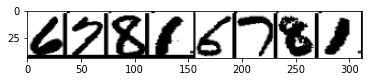

In [181]:
stitch_images_horizontally(inp_files=["../data/processed/train/2.png", "../data/processed/train/42.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type4")

Image 1


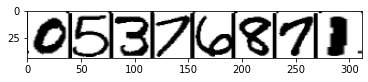

Image 2


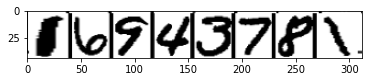

Cropped Image 1


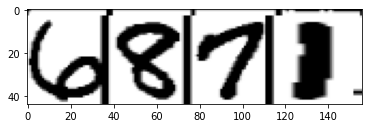

Cropped Image 2


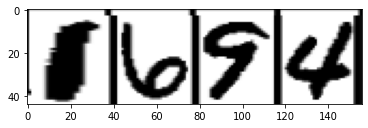

Stitched Image (Image1-4, Image2-4)


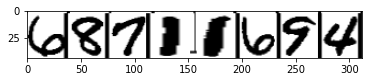

In [153]:
stitch_images_horizontally(inp_files=["../data/processed/train/584.png", "../data/processed/train/585.png"], 
                           height=44, width=312, 
                           digits1=4, digits2=4, comb_type="type2")